In [0]:
# Load Gold Layer 
df = spark.read.format('delta').load('/mnt/gold/ratail_inventory/products')

In [0]:
df.show()
df.printSchema()


+----------+--------------------+----------+----------+-----------+-----------+
|product_id|        product_name|model_year|list_price|supplier_id|category_id|
+----------+--------------------+----------+----------+-----------+-----------+
|         1|   Trek 820 - 2016  |      2016|    379.99|          9|          6|
|         2|Ritchey Timberwol...|      2016|    749.99|          5|          6|
|         3|Surly Wednesday F...|      2016|    999.99|          8|          6|
|         4|Trek Fuel EX 8 29...|      2016|   2899.99|          9|          6|
|         5|Heller Shagamaw F...|      2016|   1320.99|          3|          6|
|         6|Surly Ice Cream T...|      2016|    469.99|          8|          6|
|         7|Trek Slash 8 27.5...|      2016|   3999.99|          9|          6|
|         8|Trek Remedy 29 Ca...|      2016|   1799.99|          9|          6|
|         9|Trek Conduit+ - 2...|      2016|   2999.99|          9|          5|
|        10|Surly Straggler -...|      2

In [0]:
# Load the necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("Forecasting").getOrCreate()

# Read the sales data from the gold layer
sales_df = spark.read.format('delta').load('/mnt/gold/ratail_inventory/orders/')  # Adjust the path based on your data structure

# Show the schema and a few rows
sales_df.printSchema()
sales_df.show()


root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- order_status: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- required_date: date (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- staff_id: integer (nullable = true)
 |-- shipped_date: date (nullable = true)

+--------+-----------+------------+----------+-------------+--------+--------+------------+
|order_id|customer_id|order_status|order_date|required_date|store_id|staff_id|shipped_date|
+--------+-----------+------------+----------+-------------+--------+--------+------------+
|       1|        259|           4|2016-01-01|   2016-01-03|       1|       2|  2016-01-03|
|       2|       1212|           4|2016-01-01|   2016-01-04|       2|       6|  2016-01-03|
|       3|        523|           4|2016-01-02|   2016-01-05|       2|       7|  2016-01-03|
|       4|        175|           4|2016-01-03|   2016-01-04|       1|       3|  2016-01-05|
|       5|   

In [0]:
# Check the schema of sales_df
sales_df.printSchema()
# Show the first few rows of sales_df
sales_df.show()



root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- order_status: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- required_date: date (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- staff_id: integer (nullable = true)
 |-- shipped_date: date (nullable = true)

+--------+-----------+------------+----------+-------------+--------+--------+------------+
|order_id|customer_id|order_status|order_date|required_date|store_id|staff_id|shipped_date|
+--------+-----------+------------+----------+-------------+--------+--------+------------+
|       1|        259|           4|2016-01-01|   2016-01-03|       1|       2|  2016-01-03|
|       2|       1212|           4|2016-01-01|   2016-01-04|       2|       6|  2016-01-03|
|       3|        523|           4|2016-01-02|   2016-01-05|       2|       7|  2016-01-03|
|       4|        175|           4|2016-01-03|   2016-01-04|       1|       3|  2016-01-05|
|       5|   

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum

# Initialize Spark session
spark = SparkSession.builder.appName("Sales Analysis").getOrCreate()

# Load DataFrames from your inventory
orders = spark.read.format('delta').load('/mnt/gold/ratail_inventory/orders/')
order_items = spark.read.format('delta').load('/mnt/gold/ratail_inventory/order_items/')
products = spark.read.format('delta').load('/mnt/gold/ratail_inventory/products/')

# Ensure the 'order_date' column is of date type
orders = orders.withColumn("order_date", col("order_date").cast("date"))

# Merge DataFrames
orders_items_merged = order_items.join(orders, on='order_id', how='inner')
sales_data = orders_items_merged.join(products, on='product_id', how='inner')

# Aggregate daily sales
daily_sales_df = sales_data.groupBy("order_date").agg(
    _sum(order_items["list_price"]).alias("daily_sales")
)

# Show the aggregated daily sales
display(daily_sales_df)

order_date,daily_sales
2016-03-01,7930.94
2017-08-11,1432.98
2017-09-11,2151.98
2017-01-06,9536.91
2018-03-17,4375.94
2016-05-03,5736.95
2016-07-26,6798.97
2016-08-15,5768.96
2016-08-31,15188.90
2016-10-03,6968.96


Databricks visualization. Run in Databricks to view.

Databricks data profile. Run in Databricks to view.

/databricks/spark/python/pyspark/sql/pandas/utils.py:109: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [daily_sales] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


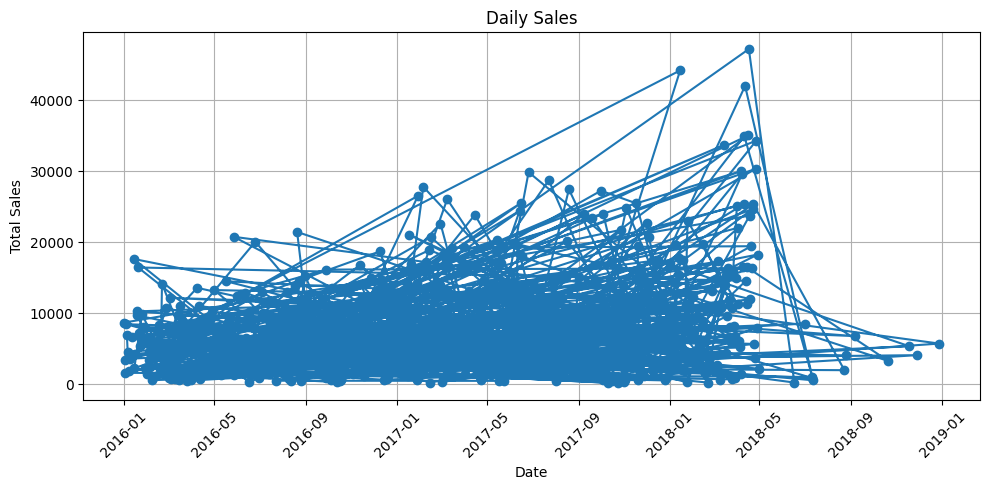

In [0]:
# Convert to Pandas DataFrame for visualization
daily_sales_pd = daily_sales_df.toPandas()

# Visualization using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(daily_sales_pd['order_date'], daily_sales_pd['daily_sales'], marker='o')
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

/databricks/spark/python/pyspark/sql/pandas/utils.py:109: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [daily_sales] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing


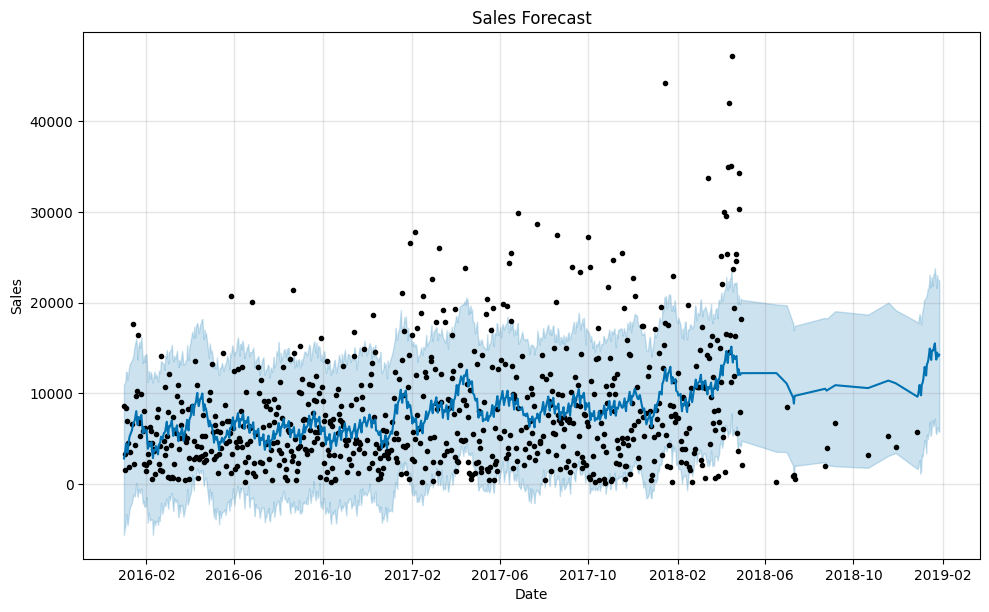

In [0]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
daily_sales_pd = daily_sales_df.toPandas()

# Prepare the data for Prophet
daily_sales_pd = daily_sales_pd.rename(columns={'order_date': 'ds', 'daily_sales': 'y'})

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(daily_sales_pd)

# Create a DataFrame for future dates
future_dates = model.make_future_dataframe(periods=30)  # Forecasting for the next 30 days

# Predict future sales
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

/databricks/spark/python/pyspark/sql/pandas/utils.py:109: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [daily_sales] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
20:33:08 - cmdstanpy - INFO - Chain [1] start processing
20:33:08 - cmdstanpy - INFO - Chain [1] done processing
2024/10/20 20:33:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Prophet_Sales_Forecast at: https://adb-2376670828231768.8.azuredatabricks.net/ml/experiments/1956234670082583/runs/9e3eb2f2f021484f93445fe4fdf5ab61.
2024/10/20 20:33:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://adb-2376670828231768.8.azuredatabricks.net/ml/experiments/1956234670082583.
2024/10/20 20:33:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/10/20 20:33:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Prophet_Sales_Forecast at: https://adb-2376670828231768.8.azuredatabricks.net/ml/experiments/1956234670082583/runs/ff7e23598d04424298332f35ae7cb519.
2024/10/20 20:33:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://adb-2376670828231768.8.azuredatabricks.net/ml/experiments/1956234670082583.


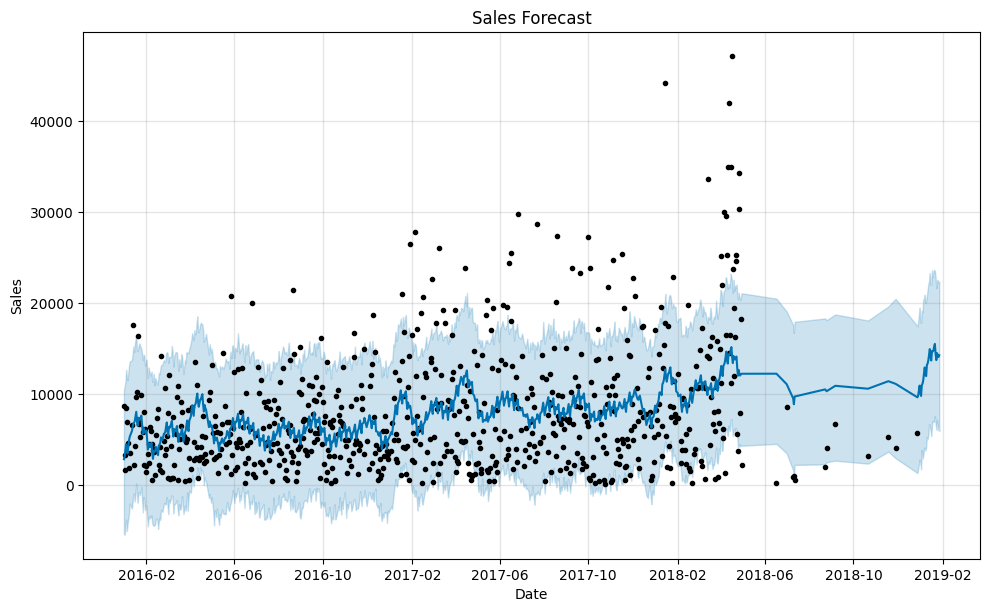

In [0]:
# Cell 9: Forecasting Model using Prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
daily_sales_pd = daily_sales_df.toPandas()

# Prepare the data for Prophet
daily_sales_pd = daily_sales_pd.rename(columns={'order_date': 'ds', 'daily_sales': 'y'})

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(daily_sales_pd)

# Create a DataFrame for future dates
future_dates = model.make_future_dataframe(periods=30)  # Forecasting for the next 30 days

# Predict future sales
forecast = model.predict(future_dates)

# Cell 10: Import and Set Up MLflow
import mlflow
import mlflow.pyfunc
import mlflow.prophet

# Start an MLflow run
mlflow.end_run()
mlflow.start_run(run_name="Prophet_Sales_Forecast")

# Cell 11: Log Model and Parameters with MLflow
# Log the model
mlflow.prophet.log_model(model, "prophet_model")

# Log parameters
mlflow.log_param("forecast_periods", 30)

# Ensure the directory exists
dbutils.fs.mkdirs("dbfs:/tmp")

# Log the forecast DataFrame as an artifact
forecast.to_csv("/dbfs/tmp/forecast.csv", index=False)
mlflow.log_artifact("/dbfs/tmp/forecast.csv")

# End the MLflow run
mlflow.end_run()

# Cell 12: Display the Forecast Plot
# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()